In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def process_cell_image(image_path):
    """
    Reads a microscopy image, processes it to detect cells, counts them,
    and visualizes the results with bounding boxes.
    """
    
    # 1. Read the image
    if not os.path.exists(image_path):
        print(f"Error: File {image_path} not found.")
        return
        
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image {image_path}.")
        return

    # 2. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Apply Gaussian smoothing
    # Kernel size (5, 5) is standard; sigmaX=0 lets OpenCV calculate it based on kernel size
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Binarize using Otsu's thresholding
    # cv2.THRESH_BINARY + cv2.THRESH_OTSU automatically finds the optimal threshold
    # Returns (threshold_value, binary_image)
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 5. Apply Morphological Opening
    # Opening (Erosion followed by Dilation) removes small noise (speckles)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # 6. Connected Component Analysis
    # connectivity=8 checks all 8 neighbors (pixels touching corners count as connected)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening, connectivity=8)

    # 7. Count the cells
    # num_labels includes the background (label 0), so we subtract 1
    cell_count = num_labels - 1
    print(f"Image: {image_path} | Detected Cells: {cell_count}")

    # 8. Visualize detected cells with bounding boxes
    output_img = img.copy()
    
    # Loop through all components (skip label 0 which is background)
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Optional: Filter out very small noise that might have survived opening
        if area > 10:  
            # Draw green rectangle (0, 255, 0) with thickness 2
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display results
    plt.figure(figsize=(15, 5))

    # Original Grayscale
    plt.subplot(1, 3, 1)
    plt.title(f"Gray + Gaussian\n({os.path.basename(image_path)})")
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')

    # Binary (Otsu + Morph Opening)
    plt.subplot(1, 3, 2)
    plt.title(f"Binary (Otsu + Opening)\nThreshold: {ret:.2f}")
    plt.imshow(opening, cmap='gray')
    plt.axis('off')

    # Result with Bounding Boxes
    plt.subplot(1, 3, 3)
    plt.title(f"Detected Cells: {cell_count}")
    # Convert BGR to RGB for Matplotlib correct color display
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Image: cell2.jpeg | Detected Cells: 177


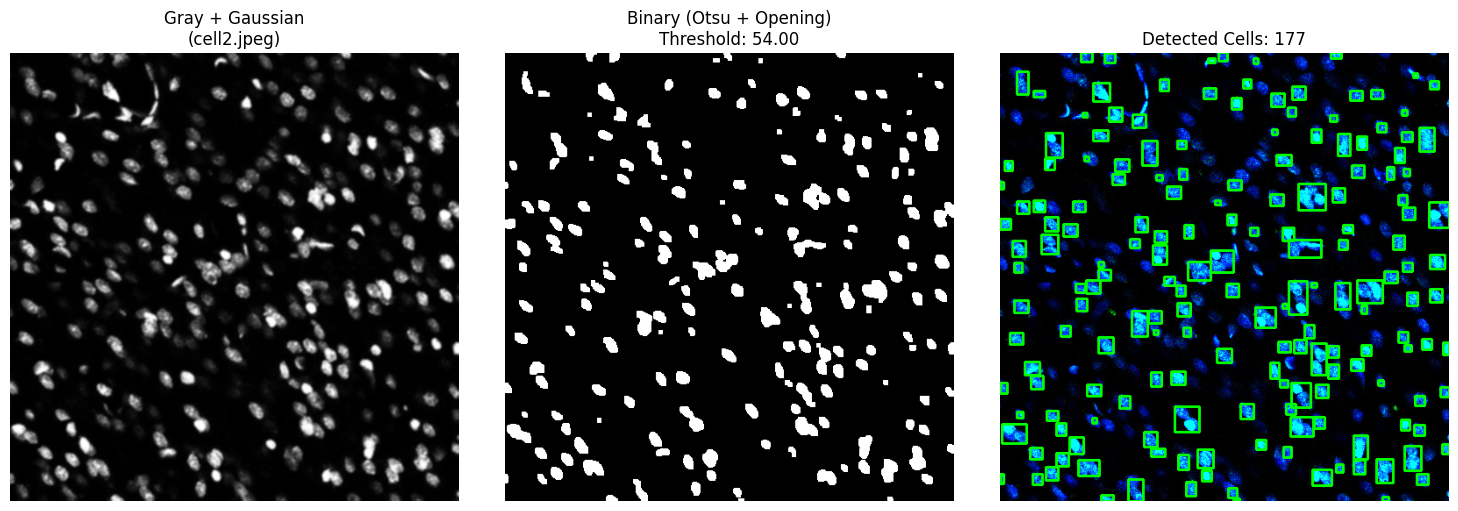

Image: cell3.png | Detected Cells: 120


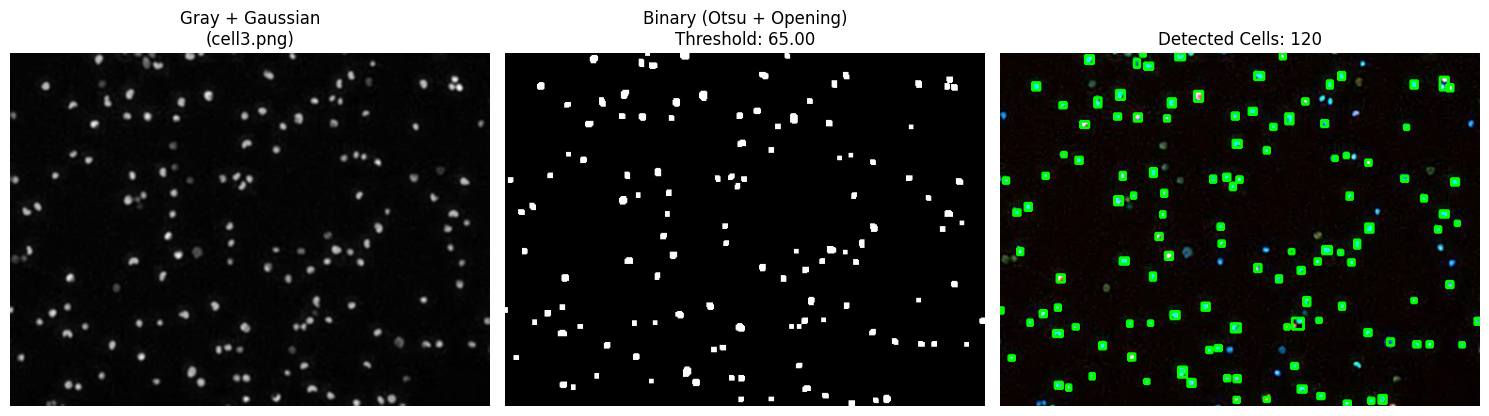

In [3]:
# --- Main Execution ---
# List of image files to process
image_files = ['cell2.jpeg', 'cell3.png']

for img_file in image_files:
    process_cell_image(img_file)